# dp100_12 Azure MLでのデータの操作

## データストアの概要

Azure MLでは、データストアはクラウドデータソースの抽象化である。  
これらには、データソースに接続するために必要な情報がカプセル化される。  
Azure ML SDKを使用して直接コード内でデータストアにアクセスし、それを使用してデータをアップロードまたはダウンロードできる。

### データストアの種類

Azure MLでは、次のような複数の種類のAzureデータソース用のデータストアの作成をサポートしている。

- Azure Storage(BLOBおよびファイルコンテナ)
- Azure Data Lake Store
- Azure SQLデータベース
- Azure Databricksファイルシステム(DBFS)

### 組み込みデータストア

各ワークスペースには、AzureMLによってシステムストレージとして使用される2つの組み込みデータストア(Azure Storage BLOBコンテナとAzure Storegeファイルコンテナ)がある。  
また、サンプルとして提供されたOpen Datasetsを(例えばサンプルデータセットに基づいてデザイナーパイプラインを使用して)利用している場合、  
ワークスペースに追加される3番目のデータストアもある。

ほとんどの機械学習プロジェクトでは、組み込みデータストアでサポートされるよりも大量のデータボリュームを格納する必要があるか、  
機械学習ソリューションを既存のアプリケーションからのデータと統合する必要があるため、自身のデータソースを操作する必要が生じる可能性がある。

## データストアを使用する

ワークスペースにデータストアを追加するには、AzureMLスタジオのグラフィカルインターフェイスを使用して登録することも、  
AzureML SDKを使用することもできる。

たとえば、次のコードでは、Azure Storage BLOBコンテナを**blob_data**という名前のデータストアとして登録している。

```
from azureml.core import Workspace, Datastore

ws = Workspace.from_config()

# 新しいデータストアの登録
blob_ds = Datastore.register_azure_blob_container(workspace=ws, 
                                                  datastore_name='blob_data', 
                                                  container_name='data_container',
                                                  account_name='az_store_acct',
                                                  account_key='123456abcde789…')
```

### データストアの管理

AzureMLスタジオでデータストアを表示及び管理することも、AzureMLSDKを使用することもできる。  
例えば、以下のコードではワークスペース内の各データストアの名前を一覧表示する。

In [1]:
from azureml.core import Workspace, Datastore

ws = Workspace.from_config()

for ds_name in ws.datastores:
    print(ds_name)

azureml_globaldatasets
workspaceblobstore
workspacefilestore


次に示すように、**Datastore.get()**メソッドを使用して、任意のデータストアを参照できる。

In [2]:
Datastore.get(ws, datastore_name='azureml_globaldatasets')

{
  "name": "azureml_globaldatasets",
  "container_name": "globaldatasets",
  "account_name": "mmstoragewestus2",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

ワークスペースは常に、規定のデータストアが含まれている。  
> ※最初は、これは組み込みの**workspaceblobstore**データストア

これは、次のように**ワークスペース**オブジェクトの**get_default_datastore()**メソッドを使用して取得できる。

In [3]:
default_store = ws.get_default_datastore()
default_store

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-322f90dd-b503-46f1-8d45-68f1641a9197",
  "account_name": "202106138491592323",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

### データストアに関する考慮事項

データストアを計画する時は、次のガイドラインを考慮すること。

- Azure Blob Storageを使用する場合、*premium*レベルのストレージにより、大規模なデータセットのI/Oパフォーマンスが向上する可能性がある。  
ただし、このオプションを使用するとコストが増加し、データの冗長性用のレプリケーションオプションが制限される可能性がある
- データファイルを使用する場合、CSV形式が非常に一般的だが、通常はParquet形式のほうがパフォーマンスが向上する。
    - ParquetはHadoopの各種プロジェクトで利用できるオープンソースのファイルフォーマット。  
    カラムナフォーマットと呼ばれるデータ保存形式で、必要なカラムのみを読み込むことでIOを削減し、データアクセス速度の向上を実現します。
- 名前でどのデータストアにもアクセスできるが、規定のデータストア(これは最初は組み込みの**workspaceblobstore**)を変更することを検討できる。

規定のデータストアを変更するには、**set_default_datastore()**メソッドを使用する。

In [4]:
ws.set_default_datastore('azureml_globaldatasets')
ws.get_default_datastore()

{
  "name": "azureml_globaldatasets",
  "container_name": "globaldatasets",
  "account_name": "mmstoragewestus2",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

In [5]:
# 設定初期化
ws.set_default_datastore('workspaceblobstore')

## データセットの概要

データセットは、実験やパイプラインで簡単に使用できる、バージョン管理されパッケージ化されたデータオブジェクト。  
データセットは、データを操作する推奨の方法であり、データのラベル付けやデータの誤差監視など、Azure MLの高度な機能のメカニズム。

### データセットの種類

データセットは、通常データストア内のファイルに基づいているが、URLやその他のソースに基づいている場合もある。

- 表形式
    - データはデータセットから表として読み取られる。データが一貫して構成されており、Pandasデータフレームなどの一般的な表形式のデータ構造内でそれを操作する場合、  
    この種類のデータセットを使用する必要がある。
- ファイル
    - データセットは、ファイルシステムからのように読み取ることのできるファイルパスのリストを掲示する。  
    データが構造化されていない場合や、ファイルレベルでデータを処理する必要がある場合(たとえば、一連のイメージファイルからCNNをトレーニングする場合)は、  
    この種類のデータセットを使用する

### データセットの作成と登録

AzureMLスタジオまたはAzureML SDKのビジュアルインターフェイスを使用して、個々のファイルまたは複数のファイルパスからデータセットを作成できる。  
パスにはワイルドカードを含めることができ、1つのデータセットに複数のファイルのデータをカプセル化できる。

作成したデータセットは、後で実験及びデータ処理パイプラインで使用できるように、ワークスペースに登録できる。

#### 表形式データセットの作成と登録

SDKを使用して表形式のデータセットを作成するには、以下のように**Dataset.Tabular**クラスの**from_delimited_files**メソッドを使用する。

```
from azureml.core import Dataset

blob_ds = ws.get_default_datastore()
csv_paths = [(blob_ds, 'data/files/current_data.csv'),
             (blob_ds, 'data/files/archive/*.csv')]
tab_ds = Dataset.Tabular.from_delimited_files(path=csv_paths)
tab_ds = tab_ds.register(workspace=ws, name='csv_table')
```

この例のデータセットには、規定のデータストア内の2つのファイルパスからのデータが含まれている。  
- **data/files**フォルダの**current_data.csv**ファイル
- **data/files/archive/**フォルダ内すべての.csvファイル

データセットを作製すると、コードによって、**csv_table**という名前のワークスペースに登録される。

### ファイルデータセットの作成と登録

SDKを使用してファイルデータセットを作製するには、次のように**Dataset.file**クラスの**from_files**メソッドを使用する。

```
from azureml.core import Dataset

blob_ds = ws.get_default_datastore()
file_ds = Dataset.File.from_files(path=(blob_ds, 'data/files/images/*.jpg'))
file_ds = file_ds.register(workspace=ws, name='img_files')
```

この例のデータセットでは、規定のデータストア内の**data/files/images**パス内のすべての.`jpg`ファイルが含まれている。  
データセットを作製すると、コードによって**img_files**という名前のワークスペースに登録される。

### 登録済みのデータセットの取得

データセットを登録した後、次のいずれかの手法を使用してデータセットを取得できる。

- **Workspace**オブジェクトの**datasets**ディクショナリ属性。
- **Dataset**クラスの**get_by_name**または**get_by_id**メソッド。

次のコードでは、両方の手法が示されている。

```
import azureml.core
from azureml.core import Workspace, Dataset

# 保存した設定ファイルからワークスペースを読み込む
ws = Workspace.from_config()

# Get a dataset from the workspace datasets collection
# ワークスペースデータセットコレクションからデータセットを取得する
ds1 = ws.datasets['csv_table']

# datasetsクラスからデータセットを名前で取得する
ds2 = Dataset.get_by_name(ws, 'img_files')
```

### データセットのバージョン管理

データセットは、バージョン管理でき、実験で使用されたデータセットの履歴バージョンを追跡して、それらの実験を同じ状態のデータで再現することができる。  
データセットの新しいバージョンを作製するには、以前に登録したデータセットと同じ名前でそのデータセットを登録し、**create_new_version**プロパティを指定する。

```
img_paths = [(blob_ds, 'data/files/images/*.jpg'),
             (blob_ds, 'data/files/images/*.png')]
file_ds = Dataset.File.from_files(path=img_paths)
file_ds = file_ds.register(workspace=ws, name='img_files', create_new_version=True)
```

この例では、**images**フォルダ内の.pngファイルが、前のトピックで使用した**img_paths**データセット例の定義に追加されている。

### 特定のデータセットのバージョンの取得

特定のバージョンのデータセットを取得するには、**Dataset**クラスの**get_by_name**メソッドで**version**パラメータを指定する。

```
img_ds = Dataset.get_by_name(workspace=ws, name='img_files', version=2)
```

## データセットを使用する

### 表敬式のデータセットを操作する

データを表形式のデータセットから直接読み取るには、**Pandas**または**Spark**データフレームに変換する。

```
df = tab_ds.to_pandas_dataframe()
# データフレームを扱うコードは、例えば個々に記述する
print(df.head())
```

#### 実験用スクリプトに表形式のデータセットを渡す

実験スクリプトでデータセットにアクセスする必要がある場合、データセットをスクリプトに渡すには以下の2つの方法がある。

- 表形式のデータセットにスクリプト変数を使用する
- 表形式のデータセットに名前付き入力を使用する

##### 表形式のデータセットにスクリプト引数を使用する

この方法を採用した場合、スクリプトによって受信される引数が、ワークスペース内のデータセットの一意のIDになる。  
このスクリプトでは、実行コンテキストからワークスペースを取得し、それを使用してデータセットをIDで取得できる。

- ScriptRunConfig:

```
env = Environment('my_env')
packages = CondaDependencies.create(conda_packages=['pip'],
                                    pip_packages=['azureml-defaults',
                                                  'azureml-dataprep[pandas]'])
env.python.conda_dependencies = packages

script_config = ScriptRunConfig(source_directory='my_dir',
                                script='script.py',
                                arguments=['--ds', tab_ds],
                                environment=env)
```

- Script:

```
from azureml.core import Run, Dataset

parser.add_argument('--ds', type=str, dest='dataset_id')
args = parser.parse_args()

run = Run.get_context()
ws = run.experiment.workspace
dataset = Dataset.get_by_id(ws, id=args.dataset_id)
data = dataset.to_pandas_dataframe()
```

##### 表形式のデータセットに名前付き入力を使用する

この方法では、データセットの**as_named_input**メソッドを使用して、データセットの名前を指定する。  
次にスクリプトで、ワークスペースからデータセットを取得せずに、実行コンテキストの**input_datasets**コレクションから名前でデータセットを取得できる。  
この方法を使用する場合、実際にはデータセットを取得するためにスクリプト引数を使用しなくても、含める必要があることに注意すること。

- ScriptRunConfig:

```
env = Environment('my_env')
packages = CondaDependencies.create(conda_packages=['pip'],
                                    pip_packages=['azureml-defaults',
                                                  'azureml-dataprep[pandas]'])
env.python.conda_dependencies = packages

script_config = ScriptRunConfig(source_directory='my_dir',
                                script='script.py',
                                arguments=['--ds', tab_ds.as_named_input('my_dataset')],
                                environment=env)
```

- Script:

```
from azureml.core import Run

parser.add_argument('--ds', type=str, dest='ds_id')
args = parser.parse_args()

run = Run.get_context()
dataset = run.input_datasets['my_dataset']
data = dataset.to_pandas_dataframe()
```

### ファイルデータセットを操作する

ファイルデータセットを使用する場合は、**to_path()**メソッドを使用して、データセットでカプセル化されたファイルパスのリストを返すことができる。

```
for file_path in file_ds.to_path():
    print(file_path)
```

#### 実験スクリプトにファイルデータセットを渡す

ファイルデータセットをスクリプトに渡すには、以下の2つの方法がある。  
ただし、データセットを渡す方法にはいくつかの重要な違いがある。

- ファイルデータセットにスクリプト引数を使用する
- ファイルデータセットの名前付き入力を使用する

##### ファイルデータセットにスクリプト引数を使用する

ファイルデータセットは、スクリプト引数として渡すことができる。  
表形式のデータセットとは異なり、ファイルデータセットの引数にはモードを指定する必要があり、これには**as_download**または**as_mount**を使用できる。  
これにより、スクリプトがデータセット内のファイルを読み取るために使用できるアクセスポイントが得られる。  
ほとんどの場合、**as_download**を使用する必要があり、この場合、スクリプトが実行されているコンピューティングの一時的な場所にファイルがコピーされる。  
ただし、実験コンピューティングには十分な記憶域がない可能性のある大量のデータを処理している場合は、**as_mount**を使用して、直接ソースからファイルをストリーミングする。

- ScriptRunConfig:

```
env = Environment('my_env')
packages = CondaDependencies.create(conda_packages=['pip'],
                                    pip_packages=['azureml-defaults',
                                                  'azureml-dataprep[pandas]'])
env.python.conda_dependencies = packages

script_config = ScriptRunConfig(source_directory='my_dir',
                                script='script.py',
                                arguments=['--ds', file_ds.as_download()],
                                environment=env)
```

- Script:

```
from azureml.core import Run
import glob

parser.add_argument('--ds', type=str, dest='ds_ref')
args = parser.parse_args()
run = Run.get_context()

imgs = glob.glob(ds_ref + "/*.jpg")
```

##### ファイルデータセットの名前付き入力を使用する

この方法では、アクセスモードを指定する前に、データセットの**as_named_input**メソッドを使用して名前を指定する。  
次に、スクリプトで実行コンテキストの**input_datasets**コレクションから名前でデータセットを取得し、そこからファイルを読み取ることができる。  
表形式データセットと同様に、名前付き入力を使用する場合は、実際にはデータセットを取得するためにスクリプト引数を使用しなくても、含める必要がある。

- ScriptRunConfig:

```
env = Environment('my_env')
packages = CondaDependencies.create(conda_packages=['pip'],
                                    pip_packages=['azureml-defaults',
                                                  'azureml-dataprep[pandas]'])
env.python.conda_dependencies = packages

script_config = ScriptRunConfig(source_directory='my_dir',
                                script='script.py',
                                arguments=['--ds', file_ds.as_named_input('my_ds').as_download()],
                                environment=env)
```

- Script:

```
from azureml.core import Run
import glob

parser.add_argument('--ds', type=str, dest='ds_ref')
args = parser.parse_args()
run = Run.get_context()

dataset = run.input_datasets['my_ds']
imgs= glob.glob(dataset + "/*.jpg")
```

## 演習 データを操作する

### ワークスペースへの接続

接続できているか確認する。

In [6]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.28.0 to work with 20210613


### データストアを操作する

AzureMLでは、データストアはAzure Storage blobコンテナなどのストレージロケーションへの参照。  
すべてのワークスペースには、デフォルトのデータストアがあり、通常はワークスペースとともに作成されたAzure Storage blobコンテナである。  
異なる場所に保存されているデータを扱う必要がある場合は、ワークスペースにカスタムデータストアを追加し、そのうちのどれかをデフォルトに設定することができる。

#### データストアの表示

以下のコードを実行し、ワークスペース内のデータストアを確認する。

In [7]:
# デフォルトデータストアの確認
default_ds = ws.get_default_datastore()

# すべてのデータストアを列挙し、どのデータストアがデフォルトであるかを示す
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name)

azureml_globaldatasets - Default = False
workspaceblobstore - Default = True
workspacefilestore - Default = False


また、AzureMLスタジオのワークスペースの**Datastores**ページで、ワークスペース内のデータストアの表示と管理を行うことができる。

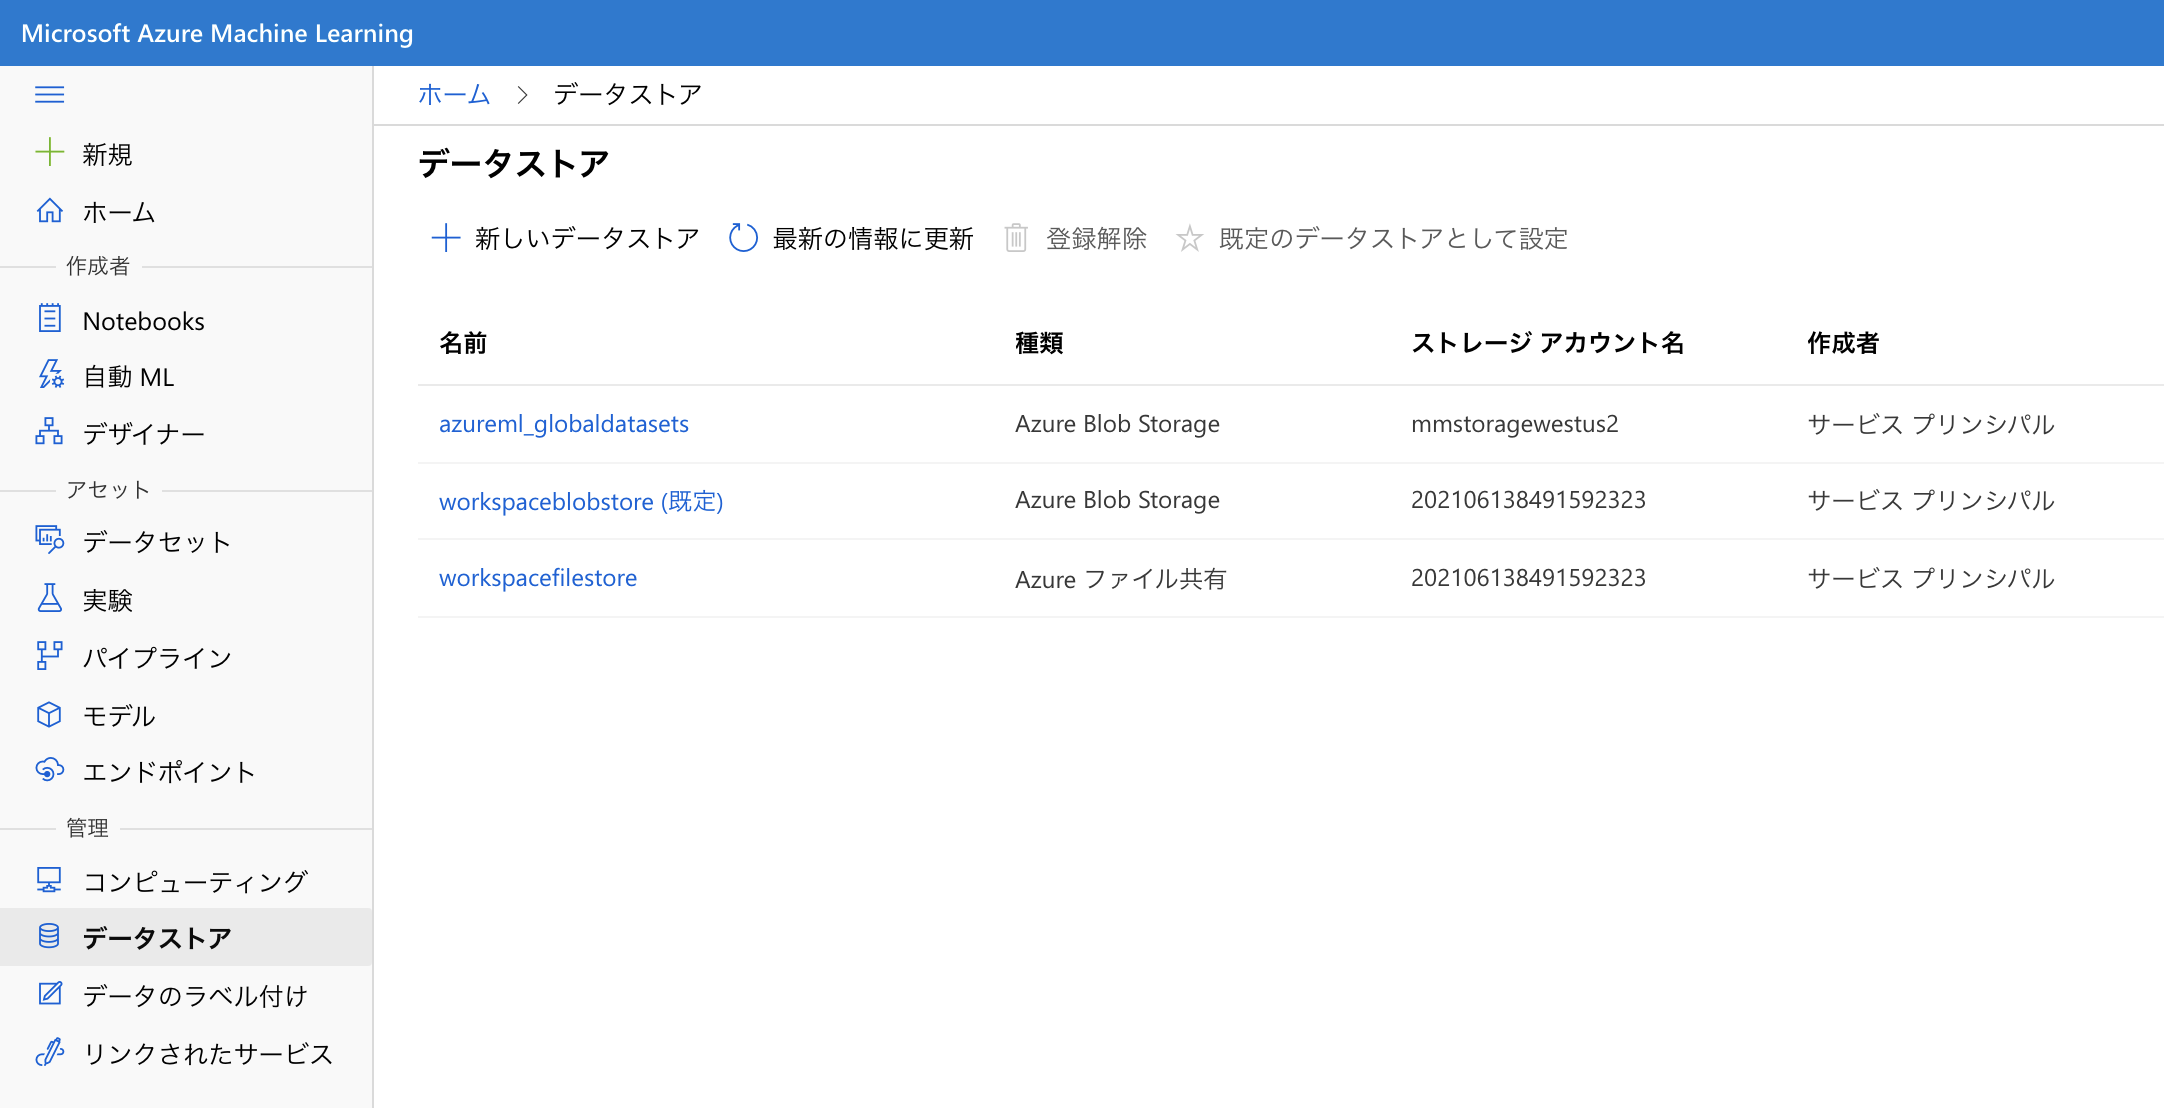

#### データストアへのデータのアップロード

利用可能なデータストアを決定したので、ローカルファイルシステムからデータストアにファイルをアップロードし、  
実験スクリプトが実際に実行されている場所に関わらず、ワークスペースで実行されている実験にアクセスできるようにすることができる。

In [8]:
default_ds.upload_files(files=['./data/diabetes.csv', './data/diabetes2.csv'], # csvファイルを/dataフォルダへアップロード
                       target_path='diabetes-data/', # データストアのフォルダパスに置く
                       overwrite=True, # 同名の既存ファイルの置き換え
                       show_progress=True)

Uploading an estimated of 2 files
Uploading ./data/diabetes.csv
Uploaded ./data/diabetes.csv, 1 files out of an estimated total of 2
Uploading ./data/diabetes2.csv
Uploaded ./data/diabetes2.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_6cb4e6db73ed443caaad55e3ee710889

### データセットの操作

AzureMLでは、データセットという形でデータを抽象化している。データセットは、実験で使用する特定のデータセットに対するバージョン管理された参照である。  
データセットには、表形式とファイル形式がある。

#### 表形式のデータセットの作成

データストアにアップロードした糖尿病データからデータセットを作成し、最初の20レコードを表示してみる。  
この場合、データは構造化された形式のCSVファイルのため、表形式のデータセットを使用する。

In [9]:
from azureml.core import Dataset

# デフォルトのデータストアを取得
default_ds = ws.get_default_datastore()

In [10]:
# データストアのパスから表形式のデータセットを作成　※時間が少しかかる
tab_data_set = Dataset.Tabular.from_delimited_files(path=(default_ds, 'diabetes-data/*.csv'))

In [11]:
# 最初の20行をPandasのデータフレームとして表示
tab_data_set.take(20).to_pandas_dataframe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
5,1619297,0,82,92,9,253,19.724160,0.103424,26,0
6,1660149,0,133,47,19,227,21.941357,0.174160,21,0
7,1458769,0,67,87,43,36,18.277723,0.236165,26,0
8,1201647,8,80,95,33,24,26.624929,0.443947,53,1
9,1403912,1,72,31,40,42,36.889576,0.103944,26,0


上のコードにあるように、表形式のデータセットをPandasのデータフレームに変換するのは簡単。

#### データセットの作成

作成したデータセットは表形式のデータセットで、データセット定義に含まれる構造化ファイルのデータをすべて含むデータフレームとして読むことができる。  
これは表形式のデータには適しているが、機械学習のシナリオによっては、構造化されていないデータを扱う必要があるかも知れないし、  
単にファイルからのデータの読み取りを独自のコードで処理したい場合もあり、このような場合には、ファイルデータセットを使用することができる。  
ファイルデータセットは、仮想マウントポイントにファイルパスのリストを作成し、これを使用してファイル内のデータを読み取ることができる。

In [12]:
# データストアのパスからデータセットファイルの作成　※少し時間がかかる
file_data_set = Dataset.File.from_files(path=(default_ds, 'diabetes-data/*.csv'))

In [13]:
# データセット内のファイルを取得
for file_path in file_data_set.to_path():
    print(file_path)

/diabetes.csv
/diabetes2.csv


#### データセットの登録

糖尿病データを参照するデータセットを作成したので、それらを登録してワークスペースで実行中の実験から簡単にアクセスできるようにする。

ここでは、表形式のデータセットを**diabetes dataset**、ファイル形式のデータセットを**diabetes files**として登録する。

In [14]:
# 表形式のデータセットを登録
try:
    tab_data_set = tab_data_set.register(workspace=ws, 
                                        name='diabetes dataset',
                                        description='diabetes data',
                                        tags = {'format':'CSV'},
                                        create_new_version=True)
except Exception as ex:
    print(ex)

In [15]:
# ファイルデータセットの登録
try:
    file_data_set = file_data_set.register(workspace=ws,
                                            name='diabetes file dataset',
                                            description='diabetes files',
                                            tags = {'format':'CSV'},
                                            create_new_version=True)
except Exception as ex:
    print(ex)

AzureMLスタジオのワークスペースの**データセット**ページで、データセットの表示及び管理できる。

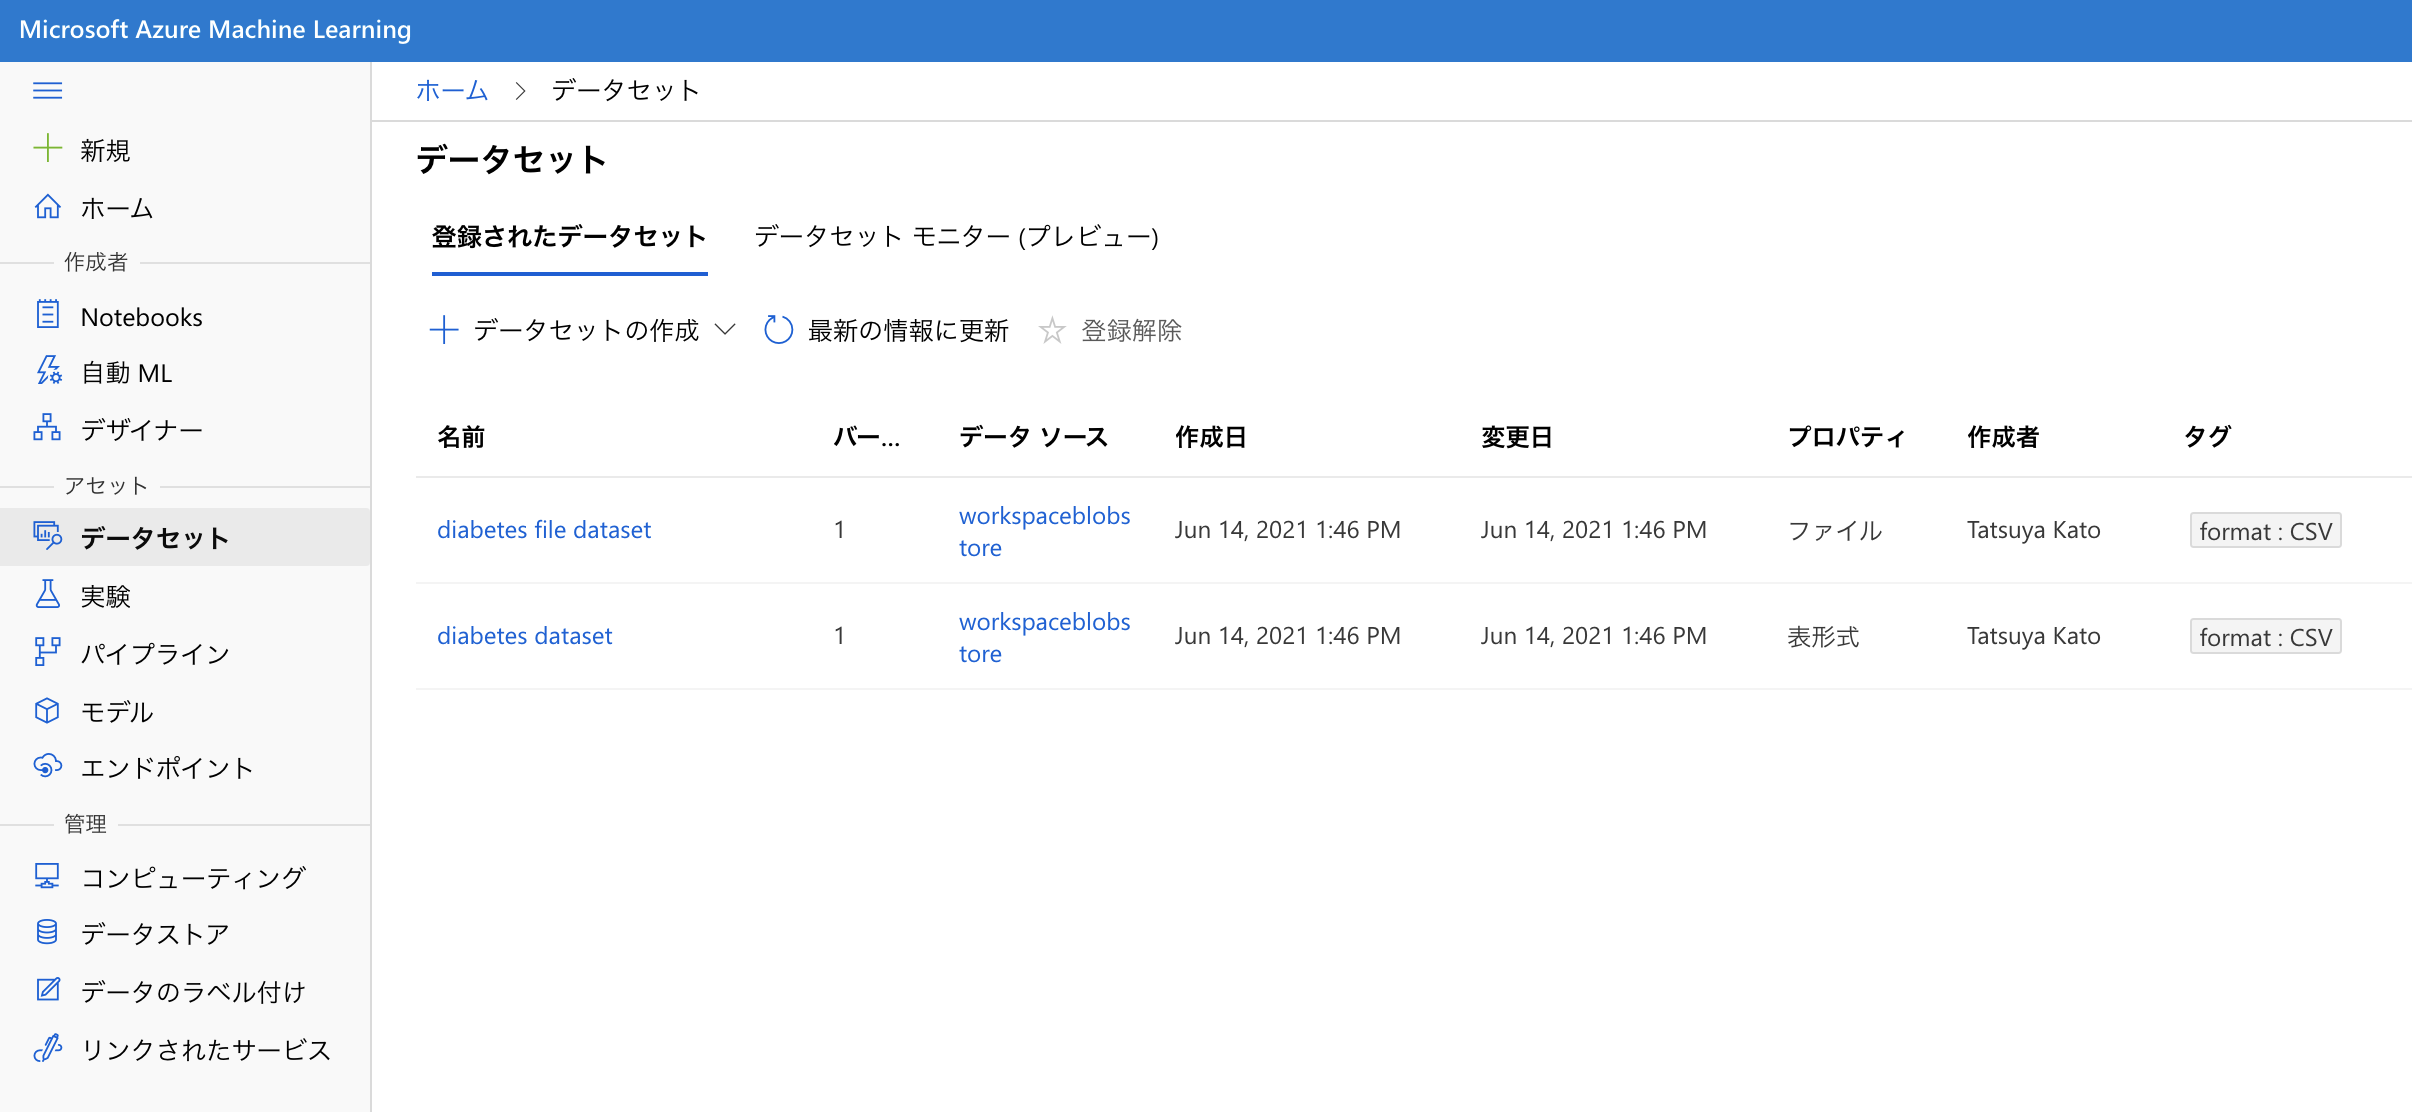

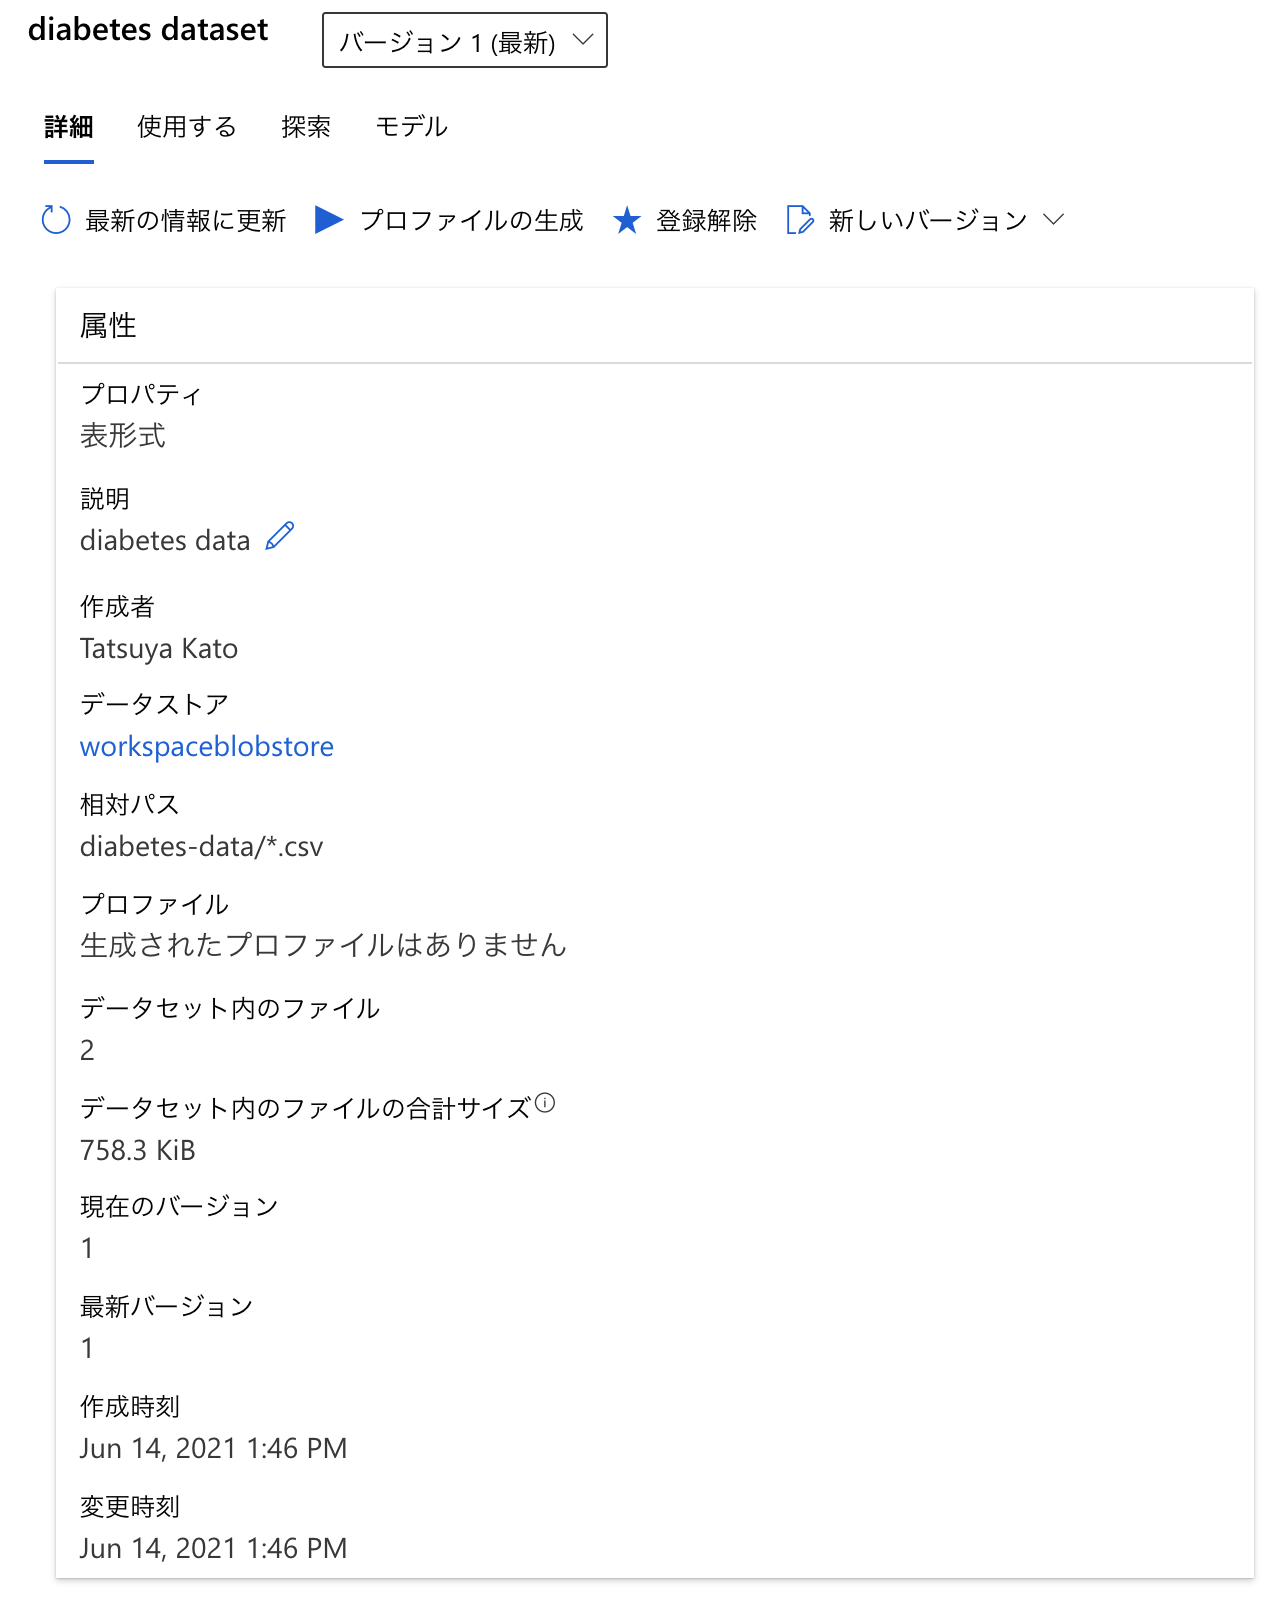

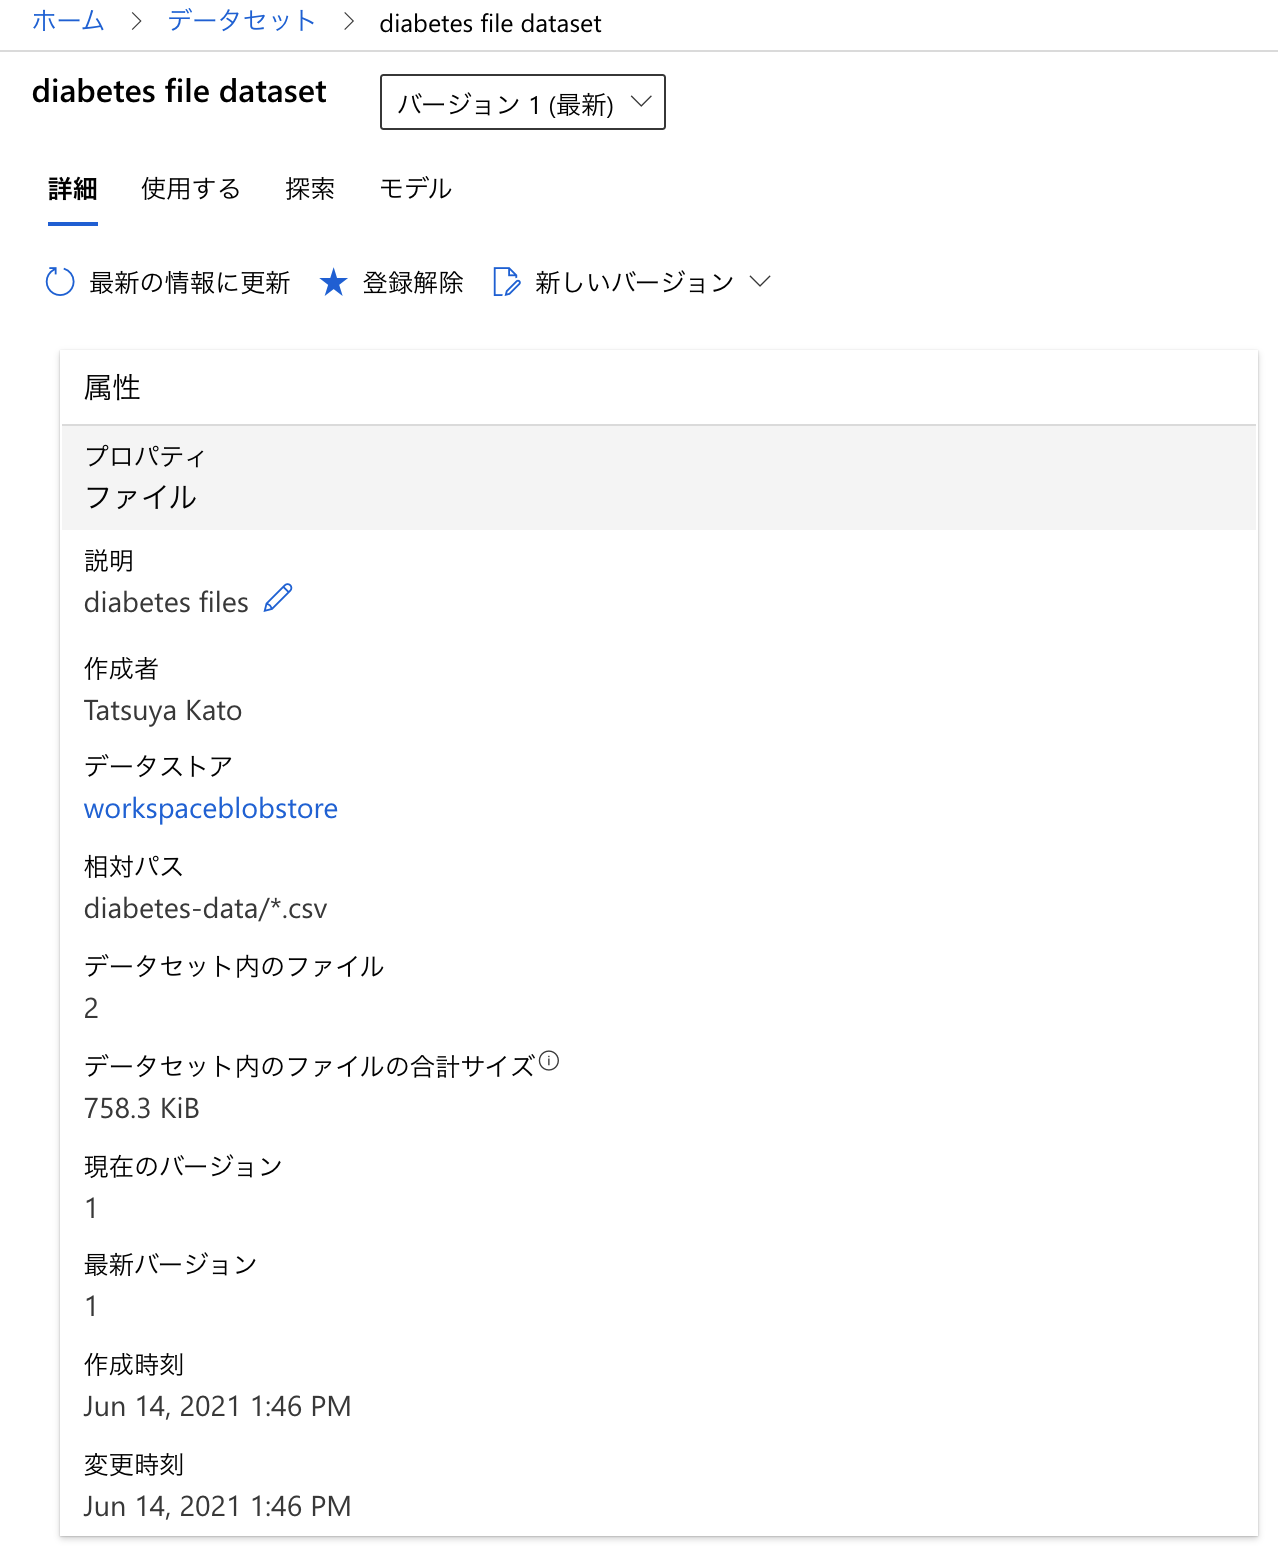

また、ワークスペースオブジェクトからデータセットのリストを取得することもできる。

In [54]:
print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name, 'version', dataset.version)

Datasets:
	 diabetes file dataset version 1
	 diabetes dataset version 1


データセットをバージョン管理することで、以前の定義に依存している既存の実験やパイプラインを壊すことなく、データセットを再定義することができる。  
デフォルトでは、名前のついたデータセットの最新バージョンが返されるが、以下のようにバージョン番号を指定することで、特定のバージョンのデータセットを取り出すことができる。

```
dataset_v1 = Dataset.get_by_name(ws, 'diabetes dataset', version = 1)
```

#### 表形式のデータセットからモデルを学習する

データセットが手に入ったので、データセットからモデルを学習する準備が整った。  
データセットは、スクリプトの実行に使われる推定器の入力としてスクリプトに渡すことができる。

以下の2つのコードセルを実行して、データセットを作製する。

1. **diabetes_training_from_tab_dataset**という名前のフォルダ
2. 引数として渡された表形式のデータセットを使って分類モデルを学習するスクリプト

In [17]:
import os

# 実験ファイル用のフォルダを作成
experiment_folder = 'diabetes_training_from_tab_dataset'
os.makedirs(experiment_folder, exist_ok=True)
print(experiment_folder, 'folder created')

diabetes_training_from_tab_dataset folder created


In [18]:
%%writefile $experiment_folder/diabetes_training.py
# ライブラリのインポート
import os
import argparse
from azureml.core import Run, Dataset
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# スクリプトの引数(正則化率とトレーニングデータセットID)を取得
parser = argparse.ArgumentParser()
parser.add_argument('--regularization', type=float, dest='reg_rate', default=0.01, help='regularization rate')
parser.add_argument("--input-data", type=str, dest='training_dataset_id', help='training dataset')
args = parser.parse_args()

# 正則化ハイパーパラメータの設定(スクリプトの引数として渡される)
reg = args.reg_rate

# 実験実行コンテキストの取得
run = Run.get_context()

# トレーニングデータセットの取得
print("Loading Data...")
diabetes = run.input_datasets['training_data'].to_pandas_dataframe()

# 特徴量とラベルを分離
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# ロジスティック回帰モデルの訓練
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# 精度計算
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# AUC計算
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

os.makedirs('outputs', exist_ok=True)

# 出力フォルダに保存されたノート・ファイルは、自動的に実験記録にアップロードされる
joblib.dump(value=model, filename='outputs/diabetes_model.pkl')

run.complete()

Overwriting diabetes_training_from_tab_dataset/diabetes_training.py


> 注:スクリプトでは、データセットはパラメータ(または引数)として渡される。表形式のデータセットの場合、この引数には登録されたデータセットのIDが含まれている。  
したがって、スクリプトの中でRunコンテキストから実験のワークスペースを取得し、そのIDを使ってデータセットを取得するコードを書くことができる。

```
run = Run.get_context()
ws = run.experiment.workspace
dataset = Dataset.get_by_id(ws, id=args.training_dataset_id)
diabetes = dataset.to_pandas_dataframe()
```

> ただし、AzureMLの実行では、名前のついたデータセットを参照している引数を自動的に識別子、実行の**input_datasets**コレクションに追加する。  
そのため、データセットのフレンドリーな名前を指定して、このコレクションからデータセットを取得することもできる。上のスクリプトではこのようにしている。

これで、スクリプトを実験として実行し、スクリプトが読み取るトレーニングデータセットの引数を定義することができる。

> 注:**Dataset**クラスは、**azureml-dataprep**パッケージの一部のコンポーネントに依存している。このパッケージには**to_pandas_dataframe()**メソッドで使用される**pandas**のオプションサポートが含まれる。  
そのため、学習実験を実行する環境にこのパッケージを含める必要がある。

In [19]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

# 実験のためのPython環境を構築
sklearn_env = Environment("sklearn-env")

In [20]:
# 必要なパッケージがインストールされていることを確認　※scikit-learn, azureml-defaults, azureml-dataprep
packages = CondaDependencies.create(conda_packages=['scikit-learn','pip'],
                                    pip_packages=['azureml-defaults','azureml-dataprep[pandas]'])
sklearn_env.python.conda_dependencies = packages

In [21]:
# トレーニングデータセットの取得
diabetes_ds = ws.datasets.get("diabetes dataset")

In [22]:
# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory=experiment_folder,
                              script='diabetes_training.py',
                              arguments = ['--regularization', 0.1, # Regularizaton rate parameter
                                           '--input-data', diabetes_ds.as_named_input('training_data')], # Reference to dataset
                              environment=sklearn_env) 

In [23]:
# 実験の実行
experiment_name = 'mslearn-train-diabetes'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-train-diabetes_1623649612_81ae9ff2',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-06-14T05:46:54.648188Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'dafbc8f8-194c-48de-936a-06871d1f1ec3',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'mlflow.source.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [{'dataset': {'id': '34c69dce-293a-4864-9539-305b47c0bf6e'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'training_data', 'mechanism': 'Direct'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_training.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--regulari

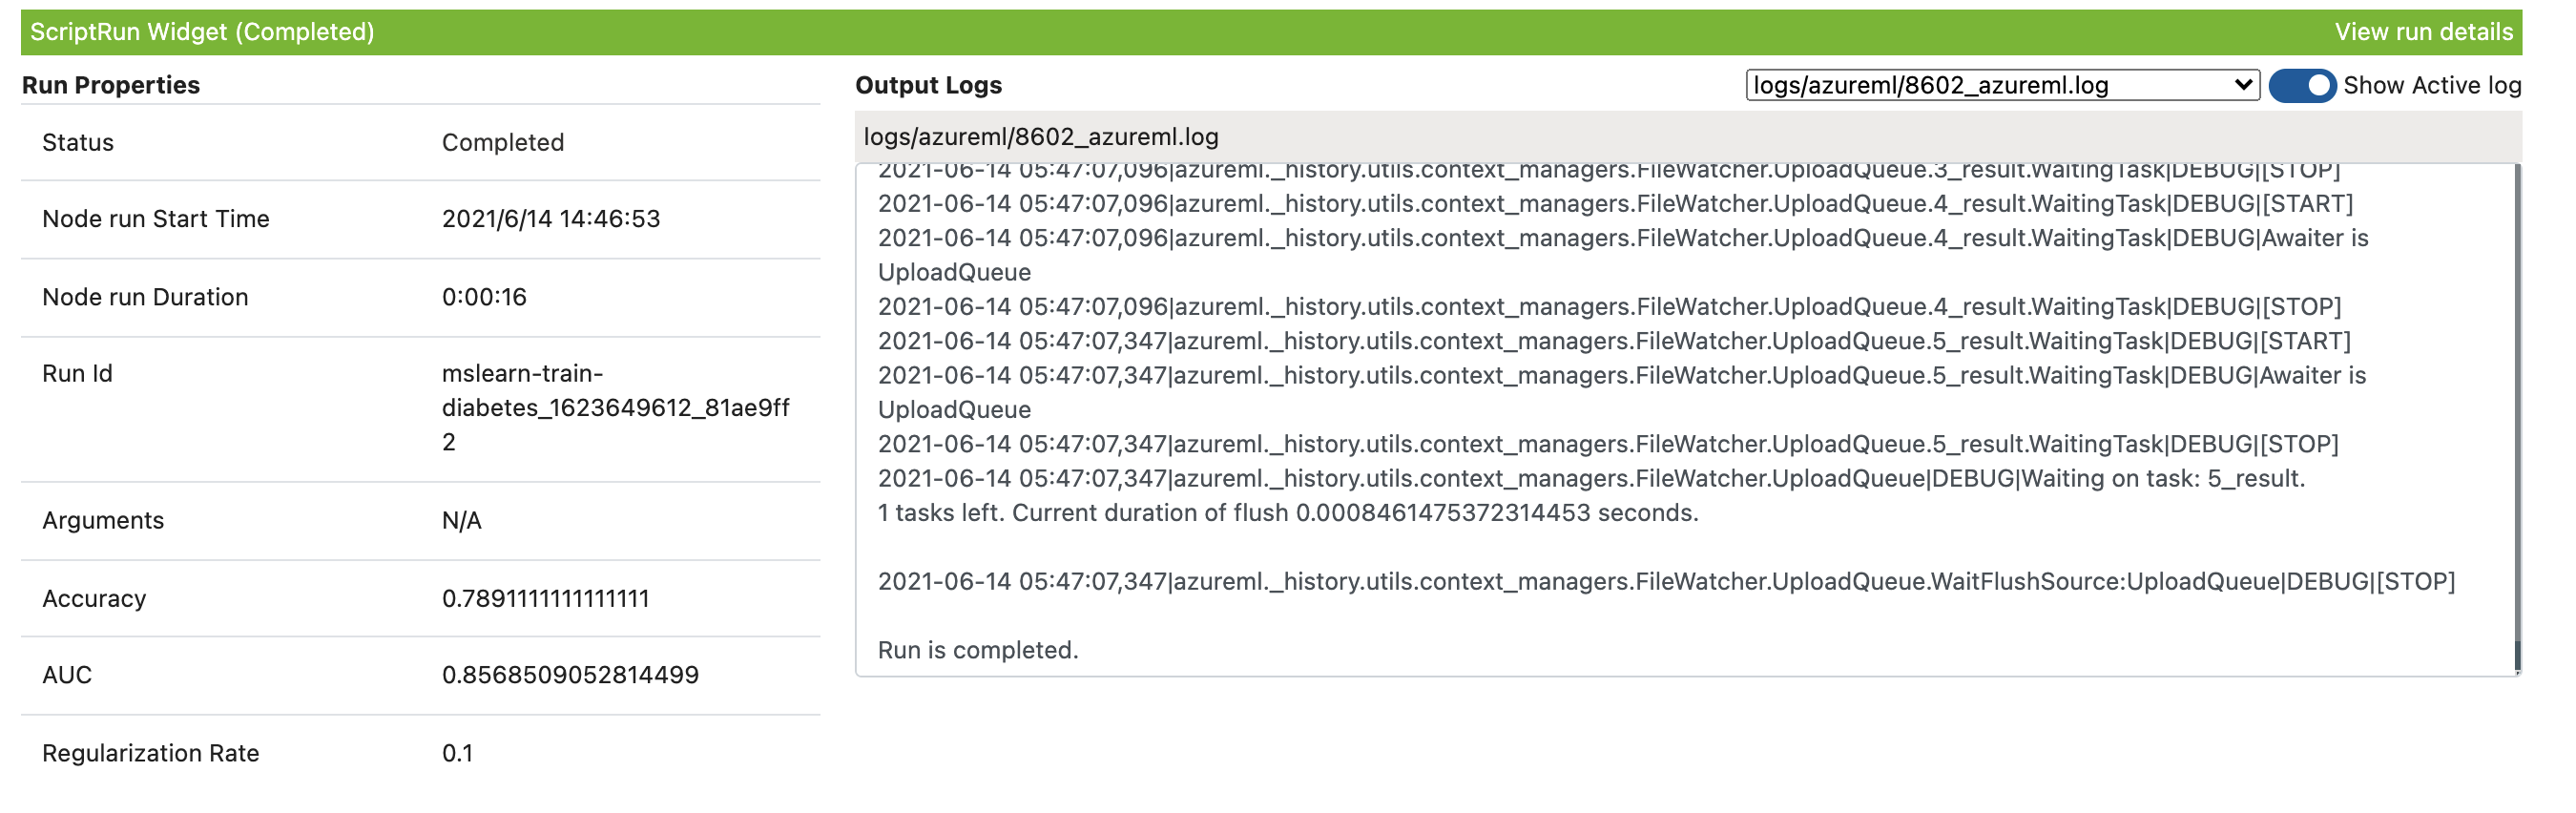

> 注:**--input-data**引数は、データセットのフレンドリーな名前を含む名前付き入力としてデータセットを私、実験実行時にスクリプトが**input_datasets**コレクションからデータセットを読み取る際に使用される。  
**--input-data**引数の文字列値は、実際には登録されたデータセットのIDである。  
別の方法として、単に`diabetes_ds.id`を渡す事もできる。この場合、スクリプトはスクリプト引数からデータセットIDにアクセスし、それを使ってワークスペースからデータセットを取得するが、  
**input_datasets**コレクションからは取得できない。

初回の実験では、Pythonの環境設定に時間がかかることがあるが、次回以降はすぐに実行できる。

実験が完了したら、ウィジェットで**azureml-logs/70_driver_log.txt**の出力ログと、実行によって生成されたメトリックを確認する。

#### 学習済みモデルの登録

他のトレーニング実験と同様に、トレーニングされたモデルを取得して、Azure MLワークスペースに登録することができる。

In [24]:
from azureml.core import Model

run.register_model(model_path='outputs/diabetes_model.pkl', model_name='diabetes_model',
                   tags={'Training context':'Tabular dataset'}, properties={'AUC': run.get_metrics()['AUC'], 'Accuracy': run.get_metrics()['Accuracy']})

for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

diabetes_model version: 4
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 3
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 2
	 Training context : Parameterized script
	 AUC : 0.8483198169063138
	 Accuracy : 0.774


diabetes_model version: 1
	 Training context : Script
	 AUC : 0.8484929598487486
	 Accuracy : 0.774




#### ファイルデータセットからモデルを学習する

ファイルデータセットを使う場合、スクリプトに渡されるデータセット引数は、ファイルパスを含むマウントポイントを表す。  
これらのファイルからどのようにデータを読み込むかは、ファイルに含まれるデータの種類や目的によって異なる。  
糖尿病のCSVファイルの場合は、Pythonの**glob**モジュールを使って、データセットで定義された仮想マウントポイントにファイルのリストを作成し、  
それらをすべてPandasのデータフレームに読み込んで、1つのデータフレームに連結する。

以下の2つのコードセルを実行して作成する。

1. **diabetes_training_from_file_dataset**という名前のフォルダ
2. 入力として渡されたファイルデータセットを使って分類モデルを学習するスクリプト

In [44]:
import os

# Create a folder for the experiment files
experiment_folder = 'diabetes_training_from_file_dataset'
os.makedirs(experiment_folder, exist_ok=True)
print(experiment_folder, 'folder created')

diabetes_training_from_file_dataset folder created


In [57]:
%%writefile $experiment_folder/diabetes_training.py
# Import libraries
import os
import argparse
from azureml.core import Dataset, Run
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import glob

# スクリプト引数を取得　※正規化率とファイルデータセットのマウントポイント
parser = argparse.ArgumentParser()
parser.add_argument('--regularization', type=float, dest='reg_rate', default=0.01, help='regularization rate')
parser.add_argument('--input-data', type=str, dest='dataset_folder', help='data mount point')
args = parser.parse_args()

# 正則化ハイパーパラメータの設定(スクリプトの引数として渡される)
reg = args.reg_rate

# 実験の実行コンテキストを取得
run = Run.get_context()

# 糖尿病データの読み取り
print("Loading Data...")
data_path = run.input_datasets['training_files'] # 入力からトレーニングデータのパスを取得
# ※ハードコードされたフレンドなり-な名前に頼りたくない場合、args.dataset_folderを使うこともできる

# ファイルの読み込み
all_files = glob.glob(data_path + "/*.csv")
diabetes = pd.concat((pd.read_csv(f) for f in all_files), sort=False)

# 特徴量とラベルの分離
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# ロジスティック回帰モデルの訓練
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# 精度計算
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# AUC計算
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

os.makedirs('outputs', exist_ok=True)
# ※ハードコードされたフレンドリーな名前に頼りたくない場合は、args.dataset_folderを使うこともできる
joblib.dump(value=model, filename='outputs/diabetes_model.pkl')

run.complete()


Overwriting diabetes_training_from_file_dataset/diabetes_training.py


表形式のデータセットと同じように、ファイルデータセットも**input_datasets**コレクションからそのフレンドリーな名前を使って取り出すことができる。  
ファイルデータセットの場合は、スクリプトの引数にファイルのマウントパスが含まれている。(表形式データセットの場合はデータセットIDではない)

次に、データセットをスクリプトに渡す方法を変更する必要がある。  
スクリプトがファイルを読み込めるパスを定義する必要がある。  
これには、**as_download**または**as_mount**メソッドを使用できる。**as_download**を使用すると、ファイルデータセット内のファイルが、  
スクリプトを実行しているコンピュータ上の一時的な場所にダウンロードされ、一方**as_mount**を使うと、データストアからファイルを直接ストリーミングできるマウントポイントが作成される。

accessメソッドと**as_named_input**メソッドを組み合わせることで、実験実行時にデータセットを**input_datasets**コレクションに含めることができる。  
※引数を`detis_ds.as_mount()`に設定するなどしてこれを省略した場合、スクリプトはスクリプト引数からデータセットのマウントポイントにアクセスできるが、  
**input_datasets**コレクションからはアクセスできないので注意

In [60]:
from azureml.core import Experiment
from azureml.widgets import RunDetails

# トレーニングデータセットを取得
diabetes_ds = ws.datasets.get("diabetes file dataset")

# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory=experiment_folder,
                                script='diabetes_training.py',
                                arguments = ['--regularization', 0.1, # 正規化率
                                             '--input-data', diabetes_ds.as_named_input('training_files').as_download()], # データセットの位置の参照
                                environment=sklearn_env) # 以前作成した環境を利用する

# 実験の実行
experiment_name = 'mslearn-train-diabetes'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-train-diabetes_1623651934_ba364d75',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-06-14T06:25:37.013355Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '0e324ad6-5d57-496b-96f4-2621d07d054a',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'mlflow.source.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [{'dataset': {'id': '831486c6-caa8-495b-9312-a039d00dbb66'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'training_files', 'mechanism': 'Download'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_training.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--regul

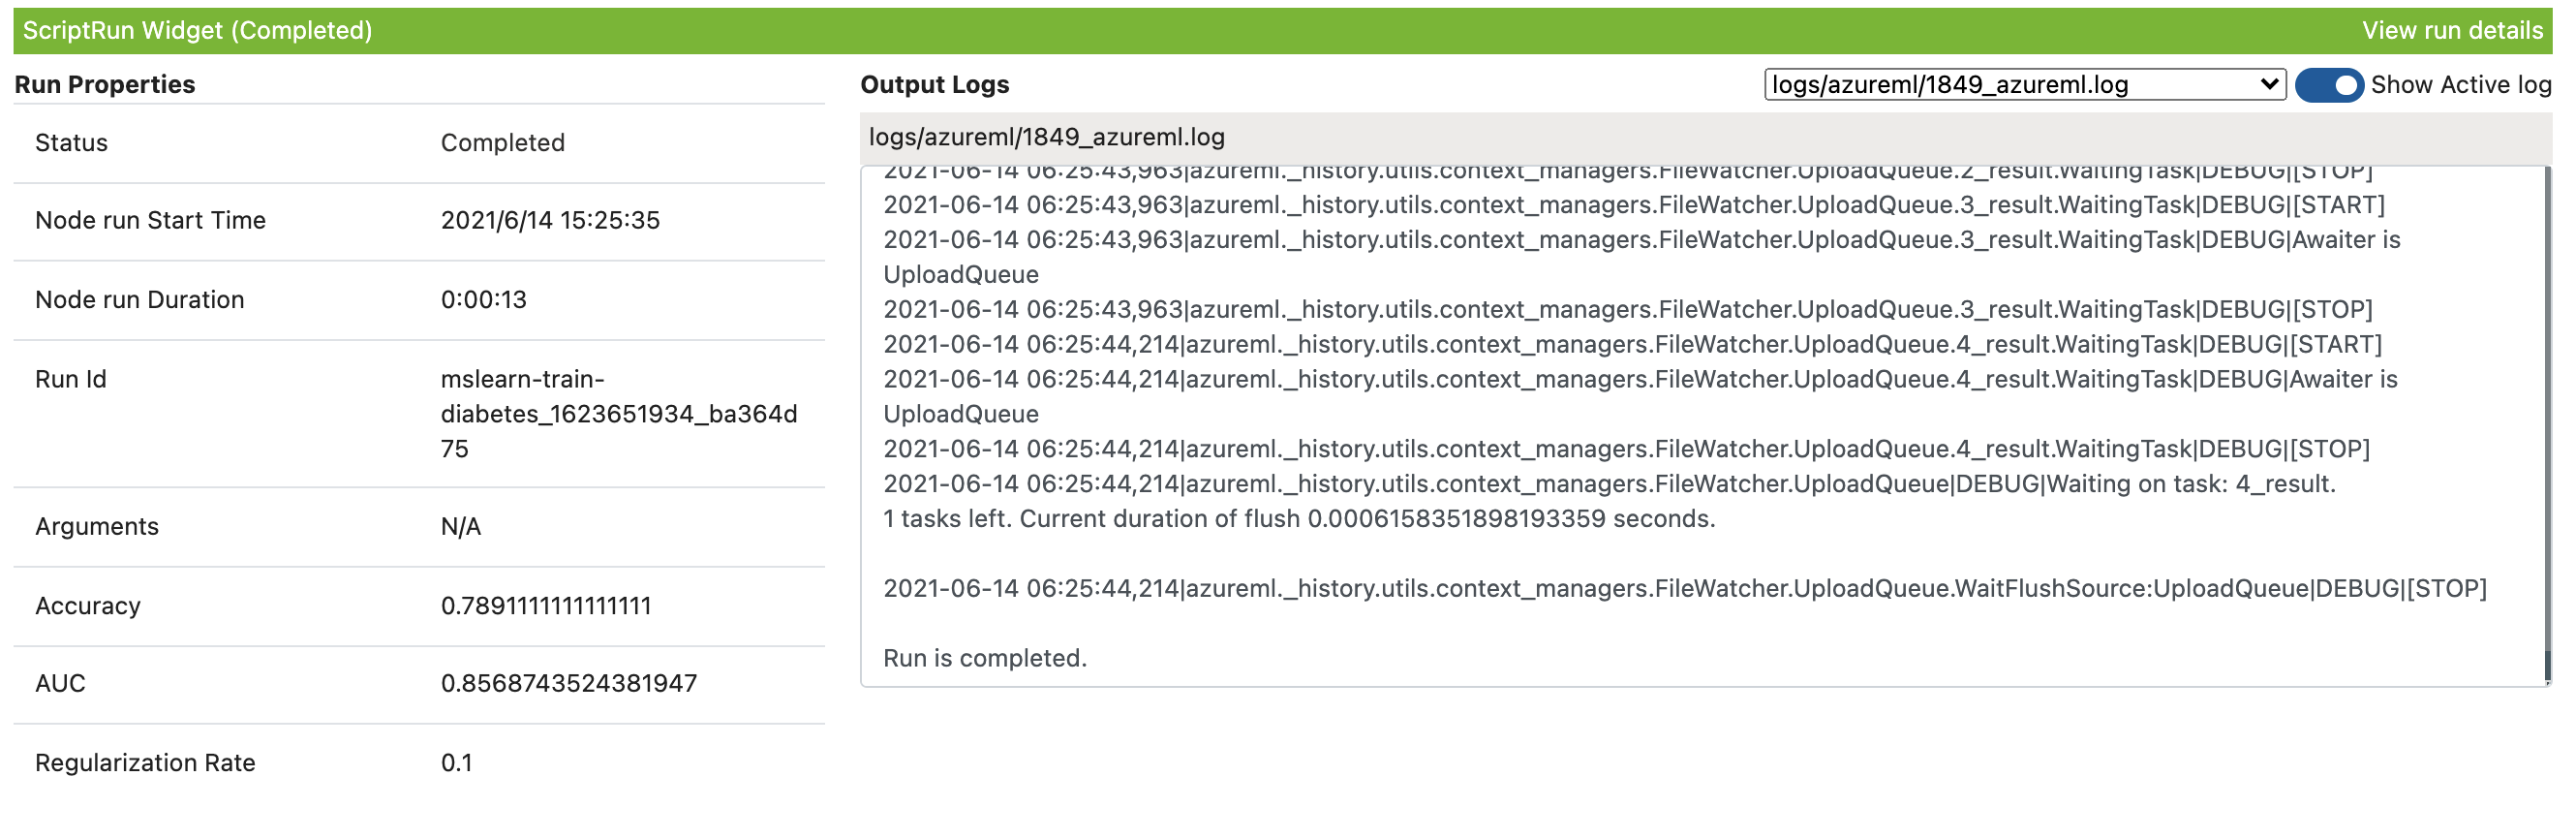

実験が終了したら、ウィジェットで**azureml-logs/70_driver_log.txt**の出力ログを見て、  
ファイルデータセットのファイルが一時フォルダにダウンロードされ、スクリプトがファイルを読み込めるようになったことを確認する。

#### 学習済みモデルの登録

改めて、実験で学習したモデルを登録する。

In [61]:
from azureml.core import Model

run.register_model(model_path='outputs/diabetes_model.pkl', model_name='diabetes_model',
                   tags={'Training context':'File dataset'}, properties={'AUC': run.get_metrics()['AUC'], 'Accuracy': run.get_metrics()['Accuracy']})

for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

diabetes_model version: 7
	 Training context : File dataset
	 AUC : 0.8568743524381947
	 Accuracy : 0.7891111111111111


diabetes_model version: 6
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 5
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 4
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 3
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 2
	 Training context : Parameterized script
	 AUC : 0.8483198169063138
	 Accuracy : 0.774


diabetes_model version: 1
	 Training context : Script
	 AUC : 0.8484929598487486
	 Accuracy : 0.774




詳細ドキュメントURL:https://docs.microsoft.com/azure/machine-learning/how-to-train-with-datasets

## 知識チェック

1. ws という名前のワークスペースへの参照があります。 どのコードで、ワークスペースの既定のデータストアを取得できますか?
- default_ds = Datastore.get(ws, 'default')
- default_ds = ws.Datastores[0]
- default_ds = ws.get_default_datastore()

2. データストアには、Pandas データフレームとして使用する構造化データの CSV ファイルが含まれます。  
この操作を簡単にするために、どの種類のオブジェクトを作成する必要がありますか?
- データストア。
- 表形式データセット。
- ファイル データセット。

3. ファイル データセットから直接データをストリーミングするためにスクリプトが必要です。 どのモードを使用する必要がありますか?
- as_mount()
- as_download()
- as_upload()

↓解答

1. default_ds = ws.get_default_datastore()
    - 既定のデータストアを取得するには、ワークスペースの get_default_datastore メソッドを使用します。
2. 表形式データセット
    - 表形式のデータセットでは、Pandas データフレームとして構造化データを使用する最も簡単な方法が提供されます。
3. as_mount()
    - ソースから直接データをストリーミングするには、as_mount モードを使用します。